In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
import sys
import rich


import xobjects as xo
import xtrack as xt
import xpart as xp

sys.path.append('../')
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.InteractionPoint as inp
import BBStudies.Physics.Detuning as dtune
import BBStudies.Physics.Base as phys
import BBStudies.Plotting.BBPlots as bbplt


LINEFOLDER   = '../Data/Lines/'
SURVEYFOLDER = '../Data/Surveys/'
df_columns = ['name', 's', 'x', 'px', 'y', 'py', 'zeta', 'delta', 'ptau', 'betx', 'bety', 'alfx', 'alfy', 'gamx', 'gamy', 'dx', 'dpx', 'dy', 'dpy', 'mux', 'muy', 'qx', 'qy', 'qs', 'dqx', 'dqy']


line   = {}
twiss  = {}
survey = {}

# Importing survey
for seq in ['lhcb1','lhcb2']:
    _beam = seq[-2:]
    survey[_beam] = pd.read_pickle(SURVEYFOLDER + f'survey_opticsfile32_{seq}.pkl')

# Importing twiss
for seq in ['lhcb1','lhcb4']:
    _beam = seq[-2:]
    
    # Importing Line
    line[_beam] = xPlus.importLine(LINEFOLDER + f'line_opticsfile32_{seq}_V2.json')
    
    # Importing twiss and tracker
    if _beam == 'b1':
        tracker = xt.Tracker(line=line[_beam])
        xtwiss  = tracker.twiss()
    else:
        xtwiss  = xt.Tracker(line=line[_beam]).twiss()
    
    twiss[_beam]= pd.DataFrame(xtwiss,columns = df_columns)
    twiss[_beam].set_index('name',inplace=True)


# Creating twiss b2 from b4
#==========================================
twiss['b2'] = xPlus.twiss_b2_from_b4(twiss['b4'])



# Clearing xsuite ouput
clear_output(wait=False)






# Filtering twiss (Needed for IP objects)
#====================================
twiss['b1'] = xPlus.filter_twiss(twiss['b1'],entries=['drift','..'])
twiss['b2'] = xPlus.filter_twiss(twiss['b2'],entries=['drift','..','bbcw'])
#====================================
B1 = inp.Beam('b1',twiss['b1'],survey['b1'],
              Nb       = 1.15e11,
              E        = 6.8e12,
              emittx_n = 2.5e-6,
              emitty_n = 2.5e-6,
              dp_p0    = 0)
    
B2 = inp.Beam('b2',twiss['b2'],survey['b2'],
              Nb       = 1.15e11,
              E        = 6.8e12,
              emittx_n = 2.5e-6,
              emitty_n = 2.5e-6,
              dp_p0    = 0)

IP1 = inp.InteractionPoint('ip1',B1,B2)
IP5 = inp.InteractionPoint('ip5',B1,B2)


beam = 'b1'
# Deactivating all wires
#===================================================
tracker.vars['enable_qff'] = 0
for IP in ['ip1','ip5']:
    tracker.vars[f"bbcw_rw_{IP}.{beam}"] = 1
    tracker.vars[f"bbcw_i_{IP}.{beam}"]  = 0

    
# Creating BB knobs
#===================================================
allVars = list(tracker.vars._owner.keys())
allElements = list(tracker.element_refs._owner.keys())


for _ip in ['ip1','ip5','ip2','ip8']:
    bb_lr = [name for name in allElements if ('bb_lr' in name)&(f'{_ip[-1]}b1' in name)]
    bb_ho = [name for name in allElements if ('bb_ho' in name)&(f'{_ip[-1]}b1' in name)]

    # New knob:
    tracker.vars[f'{_ip}_bblr_ON'] = 1
    tracker.vars[f'{_ip}_bbho_ON'] = 1

    # Linking to new knob
    for _lr in bb_lr:
        tracker.element_refs[_lr].n_particles      = tracker.vars[f'{_ip}_bblr_ON']*tracker.element_refs[_lr].n_particles._value
    for _ho in bb_ho:
        tracker.element_refs[_ho].slices_other_beam_num_particles = tracker.vars[f'{_ip}_bbho_ON']*tracker.element_refs[_ho].slices_other_beam_num_particles._value[0]

# Creating sext and oct knobs
#====================================================
ks = [name for name in allVars if ('ksf' in name)|('ksd' in name)]
ko = [name for name in allVars if ('kof.a' in name)|('kod.a' in name)]

tracker.vars['all_oct_ON']  = 1
tracker.vars['all_sext_ON'] = 1
for _ks in ks:
    if tracker.vars[_ks]._expr is None:
        tracker.vars[_ks] = tracker.vars['all_sext_ON']*tracker.vars[_ks]._value
    else:
        tracker.vars[_ks] = tracker.vars['all_sext_ON']*tracker.vars[_ks]._expr 
for _ko in ko:
    if tracker.vars[_ko]._expr is None:
        tracker.vars[_ko] = tracker.vars['all_oct_ON']*tracker.vars[_ko]._value
    else:
        tracker.vars[_ko] = tracker.vars['all_oct_ON']*tracker.vars[_ko]._expr 

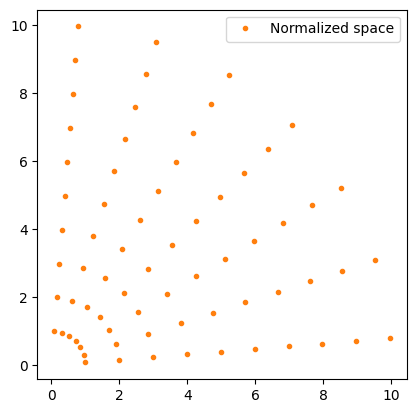

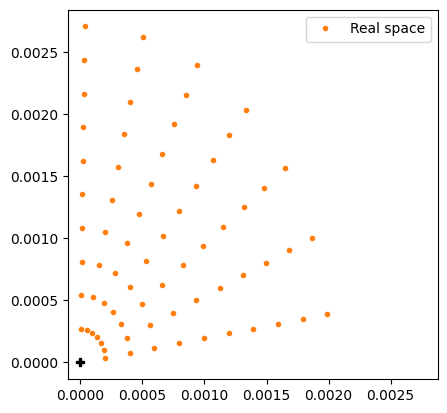

In [2]:

def generate_particles():
    # Generating Coord grid
    #=========================================================
    coordinates = phys.polar_grid(  r_sig     = np.linspace(1,10,10),
                                    theta_sig = np.linspace(0.05*np.pi/2,0.95*np.pi/2,7),
                                    emitt     = [B1.emittx,B1.emitty])



    # Generation
    p0        = xp.Particles(mass0=tracker.line.particle_ref.mass0, q0 = tracker.line.particle_ref.q0 , p0c=tracker.line.particle_ref.p0c)
    particles = xp.build_particles( particle_ref = p0,
                                    tracker      = tracker,
                                    x_norm       = coordinates['x_sig'].values, 
                                    px_norm      = None, 
                                    y_norm       = coordinates['y_sig'].values, 
                                    py_norm      = None,
                                    zeta         = None,
                                    delta        = None,
                scale_with_transverse_norm_emitt = [B1.emittx_n,B1.emitty_n])
    
    return particles,coordinates



particles,coordinates = generate_particles()


plt.figure()
plt.plot(coordinates['x_sig'],coordinates['y_sig'],'.',color='C1',label='Normalized space')
plt.axis('square')
plt.legend()

plt.figure()
plt.plot(particles.x   ,particles.y    ,'.',color='C1',label='Real space')
plt.plot(twiss['b1'].loc['ip3','x'],twiss['b1'].loc['ip3','y'],'P',color='k')
plt.axis('square')
plt.legend()



---

# Tracking


Final twiss parameters
Qx = 62.31009 Qy = 60.32004 Q'x = 15.00238 Q'y = 15.00298


Output()

generating ./9238acadb7134a19981c2fd103d9214d.c
the current directory is '/home/phbelang/abp/BBStudies/Examples'
running build_ext
building '9238acadb7134a19981c2fd103d9214d' extension
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -I/home/phbelang/abp/BBStudies/Executables/py_BB/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include/python3.9 -c 9238acadb7134a19981c2fd103d9214d.c -o ./9238acadb7134a19981c2fd103d9214d.o -std=c99 -O3 -Wno-unused-function


gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -shared -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -L/home/phbelang/abp/BBStudies/Executables/miniconda/lib -L/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -L/home/phbelang/abp/BBStudies/Executables/miniconda/lib ./9238acadb7134a19981c2fd103d9214d.o -o ./9238acadb7134a19981c2fd103d9214d.cpython-39-x86_64-linux-gnu.so -std=c99 -O3


(0.295, 0.34500000000000003)

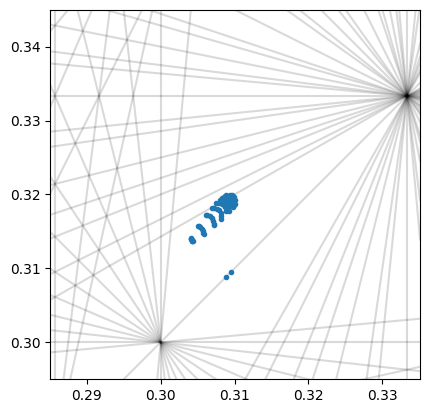

In [3]:


# Matching
#===================================
for _ip in ['ip1','ip5','ip2','ip8']:
    tracker.vars[f'{_ip}_bblr_ON'] = 0
    tracker.vars[f'{_ip}_bbho_ON'] = 0
tracker.vars['all_oct_ON']   = 1
tracker.vars['all_sext_ON']  = 1
tracker.match(vary=['dqx.b1','dqy.b1','dqpx.b1_sq','dqpy.b1_sq'],
    targets = [
        ('qx', 62.31),
        ('qy', 60.32),
        ('dqx', 15.0),
        ('dqy', 15.0)])

tw_final = tracker.twiss()
Qx_0,Qy_0 = np.round(np.mod(tw_final['qx'],1),4),np.round(np.mod(tw_final['qy'],1),4)
print('\nFinal twiss parameters')
print(f"Qx = {tw_final['qx']:.5f} Qy = {tw_final['qy']:.5f} "
      f"Q'x = {tw_final['dqx']:.5f} Q'y = {tw_final['dqy']:.5f}")
#===================================


# Choosing knobs
#==========================
tracker.vars[f'ip1_bbho_ON'] = 1
tracker.vars[f'ip5_bbho_ON'] = 1

tracker.vars[f'ip1_bblr_ON'] = 0
tracker.vars[f'ip5_bblr_ON'] = 0

tracker.vars['all_oct_ON']   = 0
tracker.vars['all_sext_ON']  = 1
#==========================


particles,coordinates = generate_particles()
tracked = xPlus.Tracking(tracker, particles, n_turns = 1024,progress=True)


window    = 0.05
Qx_lim    = [Qx_0-window/2,Qx_0+window/2]
Qy_lim    = [Qy_0-window/2,Qy_0+window/2]

plt.figure()
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)
plt.plot(tracked.tunes['Qx'],tracked.tunes['Qy'],'.')
plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')

plt.legend()
plt.axis('square')
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)

(0.295, 0.34500000000000003)

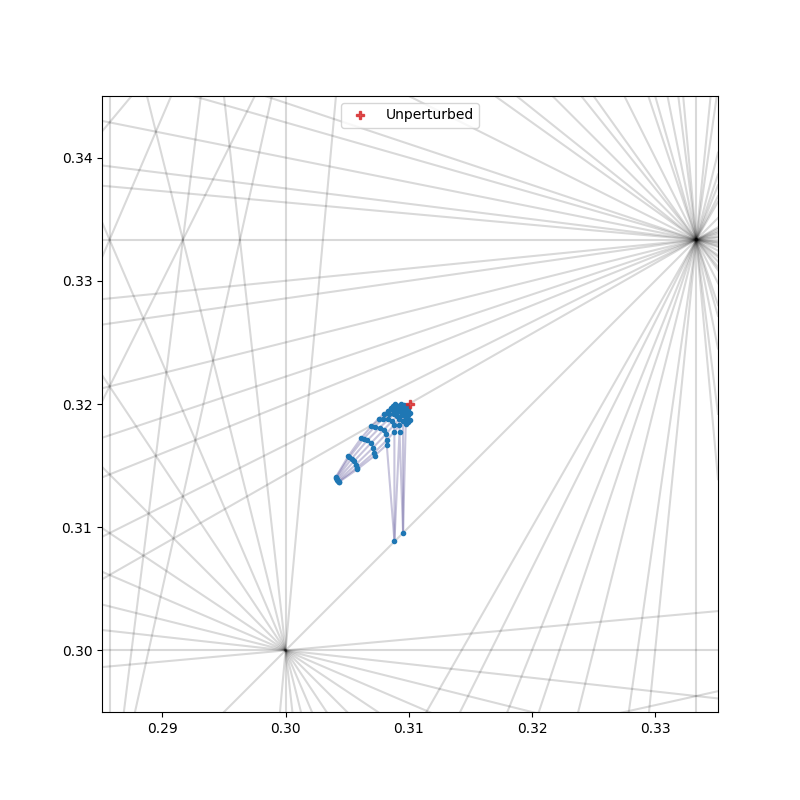

In [4]:
%matplotlib widget

window    = 0.05
Qx_lim    = [Qx_0-window/2,Qx_0+window/2]
Qy_lim    = [Qy_0-window/2,Qy_0+window/2]

plt.figure(figsize=(8,8))
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)
tracked._tunesMTD = 'pynaff'
bbplt.polarmesh(tracked.tunes['Qx'],tracked.tunes['Qy'],r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
plt.plot(tracked.tunes['Qx'],tracked.tunes['Qy'],'.')
plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')


plt.legend()
plt.axis('square')
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)